# Visual Transformer (ViT)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision

import numpy as np
import cv2
import math
import matplotlib.pyplot as plt

### The dataset

We will use the Imagenette, the 320px version. We have 10 classes

In [2]:
# This is from https://github.com/DIAGNijmegen/StreamingCNN/blob/master/Imagenette%20example.ipynb

from PIL import Image
from pathlib import Path


class ImagenetteDataset(object):
    def __init__(self, patch_size=320, validation=False, should_normalize=True):
        self.folder = Path('./data/imagenette2-320/train') if not validation else Path('./data/imagenette2-320/val')
        self.classes = ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079',
                        'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']

        self.images = []
        for cls in self.classes:
            cls_images = list(self.folder.glob(cls + '/*.JPEG'))
            self.images.extend(cls_images)
        
        self.patch_size = patch_size
        self.validation = validation
        
        # self.random_resize = torchvision.transforms.RandomResizedCrop(patch_size)
        self.center_resize = torchvision.transforms.CenterCrop(patch_size)
        self.should_normalize = should_normalize
        self.normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
    def __getitem__(self, index):
        image_fname = self.images[index]
        image = Image.open(image_fname)
        label = image_fname.parent.stem
        label = self.classes.index(label)
        
        # TODO: this is for random resizing 
        # if not self.validation: image = self.random_resize(image)
        # else: image = self.center_resize(image)
        image = self.center_resize(image)

        image = torchvision.transforms.functional.to_tensor(image)
        if image.shape[0] == 1: image = image.expand(3, 320, 320)
        if self.should_normalize: image = self.normalize(image)
        
        return image, label

    def __len__(self):
        return len(self.images)

In [3]:
trainset = ImagenetteDataset(320)
valset = ImagenetteDataset(320, validation=True)

In [4]:
class_names = ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump','golf ball', 'parachute']

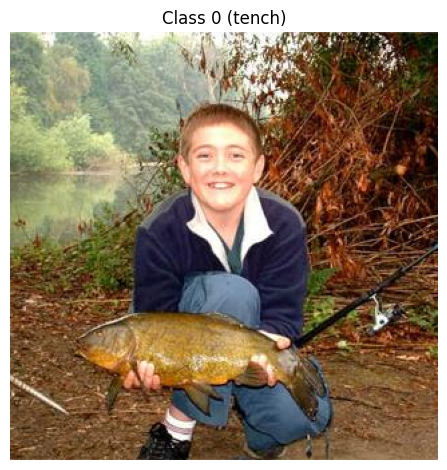

In [5]:
visualize_trainset = ImagenetteDataset(320, validation=False, should_normalize=False)
sample, label = visualize_trainset[0]
plt.imshow(sample.numpy().transpose(1,2,0))
plt.title(f"Class {label} ({class_names[label]})")
plt.axis('off')
plt.tight_layout()


### The model

In [6]:
# ---------------------------
#
# PatchEmbedding
#
# --------------------------

'''
This is the token embedding. We use the trick of creating the patches and embedding at once, 
using a conv layer. NICE TRICK!!!
'''
# The size of the patch must divide the size of the images!

class PatchEmbedding(nn.Module):
    def __init__(self, patch_size, in_channels = 3, dim_emb = 768):
        super().__init__()
        self.proj = nn.Conv2d(in_channels=in_channels, out_channels=dim_emb, kernel_size=patch_size,stride=patch_size) 
        self.dim_emb = dim_emb

    def forward(self, x):
        x = self.proj(x) # (batch, 3, size, size) ->  (batch, dim_emb, size/patch_size, size/patch_size = npatch)
        x = torch.permute(x, (0, 2, 3, 1)) # (batch, dim_emb, npatch, npatch) -> (batch, npatch, npatch, dim_emb)
        x = x.view(x.shape[0], -1, self.dim_emb) # (batch, npatch, npatch, dim_emb) -> (batch, npatch**2, dim_emb)
        return x # (batch, npatch, npatch, dim_emb)

In [7]:
a = torch.randn(10, 3, 320, 320)
npatch = 16
assert 320 % npatch == 0
patch_size = 320//npatch
patch_embedding = PatchEmbedding(patch_size=patch_size, in_channels=3, dim_emb=768)
b = patch_embedding(a)
a.shape, b.shape

(torch.Size([10, 3, 320, 320]), torch.Size([10, 256, 768]))

In [8]:
# ---------------------------
#
# Positional Encoder
#
# --------------------------

'''
The positional encoder. We need to add the postion to the token embedding. In the paper, they use trainable 1d position embeddings.
'''
def positional_encoding(npatch, dim_emb, class_token = False):
    npatch = npatch**2 # we are dealing with images
    if class_token: npatch += 1
    emb = nn.Embedding(int(npatch), dim_emb)
    pe = emb(torch.arange(0, npatch)) # .unsqueeze(0).repeat(batch_size, 1, 1) add this later
    return pe # (npatch, dim_emb) or (npatch+1, dim_emb) if class_token

In [9]:
npatch = 16
dim_emb = 768
pos_enc = positional_encoding(npatch, dim_emb, class_token = True)
pos_enc.shape

torch.Size([257, 768])

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class LayerNorm(nn.Module):
    # is basically a batch norm (less complicated) across context dimension
    def __init__(self, dim, eps : float = 1e-6):
        super().__init__()
        self.eps = eps
        self.dim = dim
        self.alpha = nn.Parameter(torch.ones(1))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        assert x.shape[-1] == self.dim, "the last layer should match the dim"
        mean = x.mean(dim=-1, keepdims=True)
        std = x.std(dim=-1, keepdims=True)
        return self.alpha * (x - mean) / (std + self.eps) + self.bias
    
class FeedForward(nn.Module):
    def __init__(self, emb_dim, hid_dim, dropout : float):
        super().__init__()
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.dropout = nn.Dropout(dropout)

        self.ff1 = nn.Linear(emb_dim, hid_dim)
        self.ff2 = nn.Linear(hid_dim, emb_dim)

    def forward(self, x):
        x = F.relu(self.ff1(x))
        x = self.dropout(x)
        x = self.ff2(x)
        return x

class ResidualConnection(nn.Module):
    def __init__(self, dim: int, sublayer : nn.Module, dropout : float = 0.):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNorm(dim)
        self.sublayer = sublayer 
        
    def forward(self, x):
        # print(self.sublayer)
        # slight different from the og paper, we first apply the norm, then the multihead block
        return x + self.dropout(self.sublayer(self.norm(x)))

# the multihead attention dividies the embedding dimension into multiple smaller attentions. 
# the number of heads must divide the input dimension (the context one)

class AttentionBlock(nn.Module):
    def __init__(self, emb_dim : int, nheads : int, dropout : float = 0.):
        super().__init__()
        assert emb_dim % nheads == 0, "nheads must divide emb_dim" # check it is divisible
        self.emb_dim = emb_dim
        self.nheads = nheads
        self.dim_head = emb_dim // nheads

        self.dropout = nn.Dropout(dropout)
        self.q = nn.Linear(emb_dim, emb_dim, bias=False)
        self.k = nn.Linear(emb_dim, emb_dim, bias=False)
        self.v = nn.Linear(emb_dim, emb_dim, bias=False)
        self.ln_out = nn.Linear(emb_dim, emb_dim, bias=False)

    @staticmethod
    def attention(query, key, values, dropout: nn.Dropout):
        dim_head = query.shape[-1]
        # print(dim_head)
        attention_scores = query @ key.transpose(-1, -2) / math.sqrt(dim_head) # (B, nhead, seq, seq) 
        attention_scores = attention_scores.softmax(dim=1) # sofmax each row (B, nhead, seq, seq)
        if dropout is not None:
            attention_scores = dropout(attention_scores)
        x = attention_scores @ values # (B, nhead, seq, dk) 
        return x, attention_scores 

    def forward(self, x): 
        # x : (B, seq, emb_dim)
        ## TODO: this is for SELF ATTENTION - DO IT FOR CROSS-ATTN TOO
        qi, ki, vi = x, x, x
        query = self.q(qi)  # (B, seq, emb_dim)
        key = self.k(ki)
        value = self.v(vi)
        
        # split across the embeding dimension and rearange. We will have (B, nhead, seq, dim_head)
        query = query.view(query.shape[0], query.shape[1], self.nheads, self.dim_head).transpose(1,2) 
        key = key.view(key.shape[0], key.shape[1], self.nheads, self.dim_head).transpose(1,2)
        value = value.view(value.shape[0],  value.shape[1], self.nheads, self.dim_head).transpose(1,2)
        
        x, self.attention_scores = AttentionBlock.attention(query, key, value, self.dropout)  # (B, nhead, seq, dk)
        
        #concat
        x = x.transpose(1,2).contiguous().view(x.shape[0], -1, self.nheads * self.dim_head) # (B, seq, emb_dim). contiguous is for the use of view?
        return self.ln_out(x) # (B, seq, emb_dim)

class Encoder(nn.Module):
    def __init__(self, emb_dim, nheads, depth, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                ResidualConnection(emb_dim, AttentionBlock(emb_dim, nheads , dropout=dropout)),
                ResidualConnection(emb_dim, FeedForward(emb_dim, hid_dim=mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            #print(attn, ff)
            x = attn(x) + x
            x = ff(x) + x
        return x



class Classifier(nn.Module):
    def __init__(self, dim_in : int, dim_ratio : float, dim_out : int, dropout : float =0.):
        super().__init__()
        self.dim_in = dim_in
        self.dim_hid = int(dim_in * dim_ratio)
        self.dim_out = dim_out
        self.fn1 = nn.Linear(self.dim_in, self.dim_hid)
        self.fn2 = nn.Linear(self.dim_hid, self.dim_out) 
        self.dropout = nn.Dropout(dropout) 

    def forward(self, x):
        x = self.fn2(F.relu(self.dropout(self.fn1(x))))
        return x

In [11]:

class Transformer(nn.Module):
    def __init__(self, 
                 npatch = 16,
                 image_size = 320, 
                 in_channels = 3, 
                 dim_emb = 768,
                 encoder_depth=12, 
                 num_heads=12,
                 mlp_ratio =4., 
                 dropout = 0.0,
                 class_ratio = 4.,
                 num_class = 10):
        super().__init__()

        # check params are ok 
        assert image_size % npatch == 0, f"n_patches {npatch} must divide signal_length {image_size}"

        '''
        ########## FOR THE ENCODER
        '''
        self.npatch = npatch
        self.signal_lenght = image_size 
        self.patch_size = image_size // npatch
        self.dim_emb = dim_emb
        self.dropout = dropout
        # this creates the patches and creates an embedding automatically. GOOD TRICK!
        self.patch_embed =  PatchEmbedding(self.patch_size, in_channels, dim_emb)
        self.positional_encoding = nn.Parameter(torch.zeros(1, npatch**2 + 1, dim_emb),
                                      requires_grad=False)

        self.cls_token = nn.Parameter(torch.zeros(1, 1, dim_emb)) # the class token

        self.encoder = Encoder(dim_emb, num_heads, encoder_depth, int(mlp_ratio * dim_emb))
        self.norm = nn.LayerNorm(self.dim_emb)


        '''
        ########## FOR THE CLASSIFIER
        '''
        self.classifier = Classifier(self.dim_emb, class_ratio, num_class)
        self.num_class = num_class

        # init the weights and parameters and stuff...
        self._init_weights()

    def _init_weights(self):
        print('init weights and positional encodings...')
        self.positional_encoding.data = positional_encoding(self.npatch, self.dim_emb, class_token=True)
        # initilaize also the weights of patch_embed and norm
        return 

    def forward_encoder(self, x): # x: (B, 1, signal_lenght) 
        # create patches and embed the tokens
        x = self.patch_embed(x) # (B, n_patch**2, dim_emb)

        # # add pos embed w/o cls token
        x = x + self.positional_encoding[1:, :].unsqueeze(0).repeat(x.shape[0], 1, 1) # (B, n_patch**2 + 1, dim_emb)
        
        # add the class token
        cls_token = self.cls_token.expand(x.shape[0], -1, -1).reshape(x.shape[0], 1, -1) + self.positional_encoding[:1, :].unsqueeze(0).repeat(x.shape[0], 1, 1)

        x = torch.cat((cls_token, x), dim=1)

        # feed the transofmer
        x = self.encoder(x)
        x = self.norm(x)

        return x  

    def forward(self, x): 
        x = self.forward_encoder(x)
        class_token = x[:, :1, :].squeeze(dim=1) # extract cls_token
        logits = self.classifier(class_token) 
        return logits

    
    ## These functions are just helpers
    def loss_fn(self, logits, target):
        return F.cross_entropy(logits, target) 

    def forward_batch(self, x, y = None):
        logits = self.forward(x) # (B, 3, 320, 320) -> (B, 10)
        targets = F.one_hot(y, num_classes=self.num_class).float()

        loss, accuracy = None, None
        if y != None: 
            loss = self.loss_fn(logits,targets)
            probs = F.softmax(logits, dim=-1)
            accuracy = torch.mean( (torch.argmax(probs, dim=-1) == y).float())

        ret = {'loss': loss, 'acc': accuracy}
        return ret

In [12]:
# Check it works
model = Transformer()
x = torch.randn(32, 3, 320, 320)
y = torch.randint(0, 10, (32, ))
out = model.forward_batch(x, y)
print(out) # we should get a loss of log(10) ~ 2.3


init weights and positional encodings...
{'loss': tensor(2.3053, grad_fn=<DivBackward1>), 'acc': tensor(0.0625)}


### Training

In [16]:
from tqdm import tqdm
import time
import sys
import math
def CFG(text, color): return "\33[38;5;" + str(color) + "m" + text + "\33[0m"

# ---------------------------
#
#  The model parameters
#
# ---------------------------

batch_size = 32
device = 'cuda:0'

model = Transformer()
# ---------------------------
#
#  Get data
#
# ---------------------------


# initialize the dataloaders after re-seed
torch.manual_seed(0)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1) # one batch
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=1)

# For now we do it like that, not the ideal, because we are creating an iterator at each call
def get_data(split):
    iterator = iter(trainloader) if split == 'train' else iter(valloader)
    x, y = next(iterator)
    x, y = x.to(device),  y.to(device)
    return x, y


# ---------------------------
#
#  Learning rate schedule
#
# ---------------------------

# learning rate decay scheduler (cosine with warmup)
warmup_iters = 2000
lr_decay_iters = 600000
min_lr = 6e-5
learning_rate = 3e-3 # max learning rate
max_iters = 600000 # total number of training iterations
weight_decay = 1e-1
beta1 = 0.9
beta2 = 0.999

def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)

# ---------------------------
#
#  Optimizer
#
# ---------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(beta1, beta2), weight_decay=weight_decay)

# ---------------------------
#
#  Configure how to evaluate the metrics
#
# ---------------------------

metrics_to_eval = ['loss', 'acc'] # they have to be returned from the method forward_batch() of the model
eval_iters = 5

@torch.no_grad()
def estimate_metrics():
    out_dicts = {s: {} for s in metrics_to_eval}
    model.eval()  # set the model to eval mode
    for split in ["train", "val"]:
        max_iters = eval_iters
        local_dicts = {s: torch.zeros(max_iters) for s in metrics_to_eval}
        for k in tqdm(range(max_iters), file=sys.stdout, desc=f"{CFG('[train]',11)}" if split == "train" else f"{CFG('[ val ]',11)}"):
            x, y = get_data(split)
            fb = model.forward_batch(x, y)
            for metric in metrics_to_eval:
                local_dicts[metric][k] = fb[metric].item()

        for metric in metrics_to_eval:
            out_dicts[metric][split] = local_dicts[metric].mean()

    model.train()  # set the model back to train mode
    return out_dicts

best_val_loss = 1e9
info = { 'iter_num': [], 'lr': [],  **{ m : {'train': [], 'val': []} for m in metrics_to_eval}}


init weights and positional encodings...


In [14]:
# ---------------------------
#
#  Train loop
#
# ---------------------------
from datetime import datetime
num_iterations = 5000
gradient_accumulation_steps = 5
log_interval = 10
eval_interval = 10
checkpoint_name = "./checkpoints/checkpoint_" + datetime.now().strftime("%y%m%d%H%M%S") + ".pt"


x, y = get_data('train') # the first batch
model.to(device)
iter_num = info['iter_num'][-1] if len(info['iter_num']) != 0 else 0
for it in range(num_iterations):
    lr = get_lr(it)
    t0 = time.time()

    # evaluate the metrics
    if iter_num % eval_interval == 0: 
        # estimate metrics at the eval_interval and convert it to numbers if tensors. Print it. Store the info
        out_estimates = {k: { s:(v[s].item() if isinstance(v[s], torch.Tensor) else v[s] ) for s in ['train', 'val'] }  for k,v in estimate_metrics().items()}
        print( CFG(f"[step {iter_num}]", 1) + ": " + "".join( [ CFG(f"train {metric}: {out_estimates[metric]['train']:.4f} ", k + 2) + CFG(f"val {metric}: {out_estimates[metric]['val']:.4f} ", k + 2) for k, metric in enumerate(metrics_to_eval) ]))
        info['lr'].append(lr); info['iter_num'].append(iter_num); [info[m]['train'].append(out_estimates[m]['train']) for m in metrics_to_eval]; [info[m]['val'].append(out_estimates[m]['val']) for m in metrics_to_eval]

    # do the backprop, we do it for gradient_accumulation_steps, to simulate larger batches. If gradient_accumulation_steps = 1, then it is like the usual
    model.train()
    for micro_step in range(gradient_accumulation_steps):
        fb = model.forward_batch(x, y) 
        loss = fb["loss"] / gradient_accumulation_steps
        x, y = get_data("train")  # get the following batch
        loss.backward()  # do the backprop, accumulate all the gradients

    # update the parameters
    for g in optimizer.param_groups:
        g['lr'] = lr

    optimizer.step()
    optimizer.zero_grad(set_to_none=True) # flush the gradients, save memory

    # log loss of batch
    t1 = time.time(); dt = t1 - t0; t0 = t1
    if iter_num % log_interval == 0: print(f"Iteration {iter_num}: Train Loss of the batch {loss.item() *  gradient_accumulation_steps:.4f}, Time {dt*1000:.2f}ms")

    if out_estimates['loss']['val'] < best_val_loss:
        best_val_loss = out_estimates['loss']['val']
        checkpoint = {
            "model": model.state_dict(),  # stores the weights of the model
            "optimizer": optimizer.state_dict(),  # stores the optimizer state
            "iter_num": iter_num,
            "best_val_loss": best_val_loss,
            "info": info,
        }
        torch.save(checkpoint, checkpoint_name)
        print("Saving checkpoint")


    # update the iterations and if terminate if necessary
    iter_num += 1
    if iter_num > max_iters: break


Iteration 210: Train Loss of the batch 1.9422, Time 6077.39ms


In [49]:
# Inference
if True:
    model = Transformer()
    
    checkpoint = torch.load("./checkpoints/checkpoint_transformer.pt", map_location=device)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    
    image, label = next(iter(trainloader)) 
    model.eval()
    logits = model.forward(image)
    probs = torch.softmax(logits, dim=-1)


init weights and positional encodings...


In [50]:
(torch.argmax(probs, dim=-1) == label).float().mean()

tensor(0.3125)

In [56]:
torch.max(probs, dim=-1), label

(torch.return_types.max(
 values=tensor([0.6922, 0.2068, 0.3197, 0.1823, 0.7726, 0.6088, 0.4942, 0.2077, 0.2316,
         0.6652, 0.2440, 0.4395, 0.6531, 0.2527, 0.2119, 0.7650, 0.2512, 0.2103,
         0.2259, 0.2799, 0.2170, 0.2611, 0.1752, 0.2634, 0.2365, 0.7376, 0.1937,
         0.1990, 0.6281, 0.2145, 0.4812, 0.3070], grad_fn=<MaxBackward0>),
 indices=tensor([9, 6, 0, 4, 9, 9, 2, 9, 7, 9, 4, 9, 9, 6, 9, 9, 6, 7, 5, 0, 9, 7, 7, 6,
         4, 9, 7, 7, 8, 4, 9, 4])),
 tensor([8, 0, 8, 0, 9, 6, 2, 3, 7, 9, 5, 2, 4, 7, 2, 9, 6, 1, 1, 1, 2, 5, 8, 9,
         4, 9, 2, 5, 8, 4, 2, 5]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


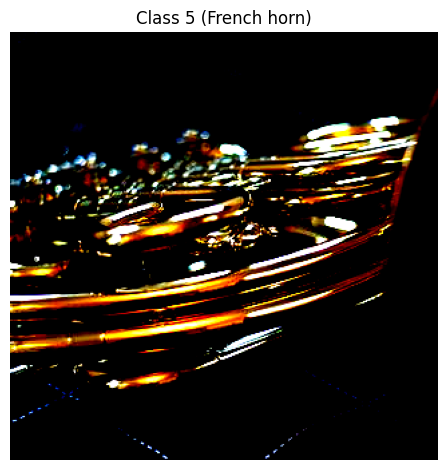

In [42]:
plt.imshow(image[4].numpy().transpose(1,2,0))
plt.title(f"Class {label[4]} ({class_names[label[4]]})")
plt.axis('off')
plt.tight_layout()

In [ ]:
# ---------------------------
#
#  Plot the metrics
#
# ---------------------------

plt.figure(figsize=(6,3))
plt.plot(info['iter_num'], info['loss']['train'], label="Train", color='blue')
plt.plot(info['iter_num'], info['loss']['val'], label="Val", color='blue', ls='dashed')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(loc='lower right')

plt.figure(figsize=(6,3))
plt.plot(info['iter_num'], info['acc']['train'], label="Train", color='blue')
plt.plot(info['iter_num'], info['acc']['val'], label="Val", color='blue', ls='dashed')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')

